**Table of contents**<a id='toc0_'></a>    
- 1. [Load data      ](#toc1_)    
  - 1.1. [Load tremor    ](#toc1_1_)    
  - 1.2. [Load earthquakes    ](#toc1_2_)    
  - 1.3. [Get tremor depth from slab    ](#toc1_3_)    
- 2. [Project events along strike   ](#toc2_)    
- 3. [Trim catalogs   ](#toc3_)    
- 4. [Compute earthquake to tremors distance  ](#toc4_)    
- 5. [Count earthquakes "felt" by tremor     ](#toc5_)    
- 6. [Inspect results ](#toc6_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [1]:
# Imports
%matplotlib widget 
import numpy as np
import pandas as pd

from scipy.spatial import cKDTree

import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter, LatitudeLocator, LongitudeLocator

import os
# if my user name is gafarge then use the following path
if os.getlogin() == 'gafarge':
    workdir = '/home/gafarge/'
elif os.getlogin() == 'root':
    workdir = '/Users/gaspard/Documents/work/'

# 1. <a id='toc1_'></a>Load data       [&#128285;](#toc0_)

## 1.1. <a id='toc1_1_'></a>Load tremor     [&#128285;](#toc0_)

In [2]:
# Load tremor
path = workdir + "projects/data/Catalogs/jp_trench_tremor_nishikawa23_16_21/JPT_tremor_catalog_updated.txt"

names = ['year', 'month', 'day', 'hour', 'minute', 'second', 'latitude', 'longitude', 'depth', 'magnitude', 'duration']
trm = pd.read_csv(path, delimiter=' ', comment='#', names=names)

trm['date'] = pd.to_datetime(trm[['year', 'month', 'day', 'hour', 'minute', 'second']])

trm.rename(columns={'latitude': 'lat', 'longitude': 'lon', 'magnitude':'mag'}, inplace=True)

## 1.2. <a id='toc1_2_'></a>Load earthquakes     [&#128285;](#toc0_)

In [3]:
# Directly load catalog from csv
eq = pd.read_csv(workdir + 'projects/data/Catalogs/JMA/jma_1951_2023.csv')
eq['date'] = pd.to_datetime(eq['date'])
eq.rename(columns={'longitude': 'lon', 'latitude': 'lat'}, inplace=True)

# Filter catalog
eq = eq[eq['evtype'] == 1]  # keep only earthquakes
eq = eq[eq['mag'] >= 1]  # keep only earthquakes with magnitude >= 1
eq = eq[eq['date'] >= '2016-01-01']  # keep only earthquakes after 2000 (shorter computation time)

lon_min = trm.lon.min() - 1
lon_max = trm.lon.max() + 1
lat_min = trm.lat.min() - 1
lat_max = trm.lat.max() + 1

indicator = (eq.lon > lon_min) & (eq.lon < lon_max) & (eq.lat > lat_min) & (eq.lat < lat_max)
eq = eq[indicator].copy()
print('{:d} events in the selected region'.format(len(eq)))

394901 events in the selected region


## 1.3. <a id='toc1_3_'></a>Get tremor depth from slab     [&#128285;](#toc0_)

In [4]:
# Slabs and trenches
# --> Pacific plate
# slab
path = workdir + "projects/data/Slabs/japan/japan_slabs_iwasaki2016/PAC_Plate/pac_regional/pac_2017_4a.xyz"
names = ['lon', 'lat', 'depth']
slab = pd.read_csv(path, sep=r'\s+', names=names)
slab.depth = -slab.depth

# contours
dir_path = workdir + "projects/data/Slabs/japan/japan_slabs_iwasaki2016/PAC_Plate/pac_regional/contour/"

files = os.listdir(dir_path)
depths = [int(file.split('_')[2]) for file in files if file.endswith('rg')]
depths = np.sort(depths)

slab_contours = dict()

for d in depths:
    path = dir_path + 'pac1_cntr_' + str(d) + '_rg'
    contour = np.loadtxt(path)
    contour = contour[:, :2]

    slab_contours[d] = {'lon': contour[:, 0], 'lat': contour[:, 1]}
    in_range = np.where((contour[:, 0] > 0) | (contour[:, 1] > 0))[0]
    slab_contours[d]['lon'] = slab_contours[d]['lon'][in_range]
    slab_contours[d]['lat'] = slab_contours[d]['lat'][in_range]

# trench
path = workdir + "projects/data/Slabs/japan/japan_slabs_iwasaki2016/Trench/japan_trench_pos"
names = ['lon', 'lat', 'water_depth', '_', '__', '___']
trench = pd.read_csv(path, sep=r'\s+', names=names)
trench = trench[['lon', 'lat', 'water_depth']]
trench = trench[trench.lon > 0]
trench.sort_values(by='lat', inplace=True)

In [5]:
# Project tremor on slab
# --> Get cartesian coordinates for everyone
crs = ccrs.TransverseMercator(central_longitude=trm.lon.mean(), central_latitude=trm.lat.mean())

trm_coords = crs.transform_points(ccrs.PlateCarree(), trm.lon.values, trm.lat.values)
eq_coords = crs.transform_points(ccrs.PlateCarree(), eq.lon.values, eq.lat.values)
slab_coords = crs.transform_points(ccrs.PlateCarree(), slab.lon.values, slab.lat.values)
depth15km_coords = crs.transform_points(ccrs.PlateCarree(), slab_contours[15]['lon'], slab_contours[15]['lat'])

trm.loc[:, 'x'] = trm_coords[:, 0]/1000  # x is easting (km)
trm.loc[:, 'y'] = trm_coords[:, 1]/1000  # y is northing (km)
eq.loc[:, 'x'] = eq_coords[:, 0]/1000
eq.loc[:, 'y'] = eq_coords[:, 1]/1000
slab.loc[:, 'x'] = slab_coords[:, 0]/1000
slab.loc[:, 'y'] = slab_coords[:, 1]/1000
slab_contours[15]['x'] = depth15km_coords[:, 0]/1000
slab_contours[15]['y'] = depth15km_coords[:, 1]/1000

# --> Find nearest neighbor
tree = cKDTree(slab[['x', 'y']].values)
dist, idx = tree.query(trm[['x', 'y']].values)
trm['depth'] = slab['depth'].values[idx]

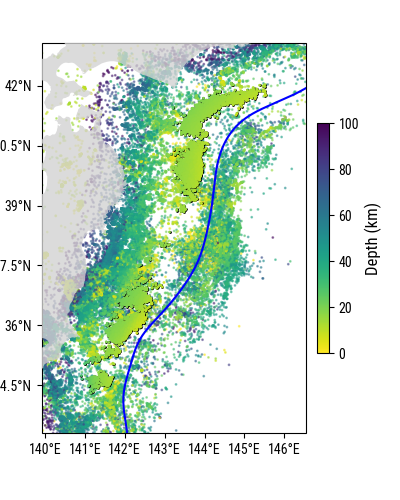

In [6]:
# Quick map

fig = plt.figure(figsize=(4, 5))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())

ax.set_extent([lon_min, lon_max, lat_min, lat_max])

ax.add_feature(cfeature.LAND, facecolor=to_rgba('lightgrey', .8), zorder=10)

ax.scatter(eq[(eq.mag > 2.) & (eq.depth < 100)].lon, eq[(eq.mag > 2.) & (eq.depth < 100)].lat, c=eq[(eq.mag > 2.) & (eq.depth < 100)].depth, s=1, alpha=.5, transform=ccrs.PlateCarree(), vmin=0, vmax=100, cmap='viridis_r')
ax.scatter(trm.lon, trm.lat, s=1, c='k', transform=ccrs.PlateCarree(),)
sc = ax.scatter(trm.lon, trm.lat, s=1, c=trm.depth, transform=ccrs.PlateCarree(), vmin=0, vmax=100, cmap='viridis_r')
plt.colorbar(sc, label='Depth (km)', pad=0.04, fraction=0.04)

ax.plot(trench.lon, trench.lat, c='b', transform=ccrs.PlateCarree())

# ticks
ax.set_xticks(np.arange(lon_min, lon_max, 2), crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(lat_min, lat_max, 2), crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
ax.xaxis.set_major_locator(LongitudeLocator())
ax.yaxis.set_major_locator(LatitudeLocator())


plt.tight_layout()
plt.show()

# 2. <a id='toc2_'></a>Project events along strike    [&#128285;](#toc0_)

In [7]:
# Fit polynomial to the 15km isodepth
in_map = (slab_contours[15]['y'] < 400) & (slab_contours[15]['y'] > -600)
p_strike = np.polyfit(slab_contours[15]['y'][in_map], slab_contours[15]['x'][in_map], 10)

# Define points on the line
y0, x0 = -600, np.polyval(p_strike, -600)   # initial point
ds = .01 # spacing along the curve in km

Y, X = [], []  # initialize the location of the points along the line
Y.append(y0)
X.append(x0)
y = y0
while y < 400:
    # Using the arc-length formula, we can find the dy to the next point,
    # and then using the polynomial, we can find the corresponding x.
    dy = ds / np.sqrt(1 + (np.polyval(np.polyder(p_strike), y))**2)
    y += dy
    x = np.polyval(p_strike, y)
    X.append(x)
    Y.append(y)

S = np.cumsum(np.ones(len(X)) * ds) - ds  # along-strike distance for each (X, Y)

# Find nearest neighbor (tremor)
tree = cKDTree(np.column_stack((X, Y)))
trm_across_strike_dist, trm_nearest_idx = tree.query(np.column_stack((trm.x, trm.y)))

trm_along_strike_dist = S[trm_nearest_idx]

trm['xf'] = trm_along_strike_dist - trm_along_strike_dist.min()
trm['yf'] = trm_across_strike_dist

# Find nearest neighbor (earthquake, takes time)
eq_across_strike_dist, eq_nearest_idx = tree.query(np.column_stack((eq.x, eq.y)))

eq_along_strike_dist = S[eq_nearest_idx]

eq['xf'] = eq_along_strike_dist - trm_along_strike_dist.min()
eq['yf'] = eq_across_strike_dist

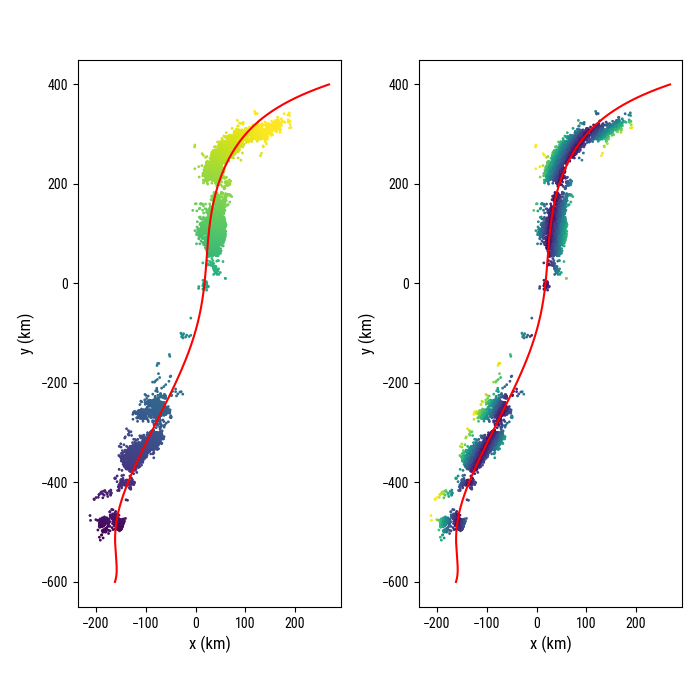

In [8]:
# Show
fig, axes = plt.subplots(1, 2, figsize=(7, 7))
for ax in axes:
    ax.set_aspect('equal')
    ax.set_xlabel('x (km)')  
    ax.set_ylabel('y (km)')
    ax.plot(X, Y, 'r', zorder=10)

# axes[0].scatter(eq.x, eq.y, s=eq.mag**3, c=eq_along_strike_dist, ec='k', cmap='viridis', vmin=0, vmax=1500)
axes[0].scatter(trm.x, trm.y, s=1, c=trm.xf, cmap='viridis', vmin=0, vmax=900)

# axes[1].scatter(eq.x, eq.y, s=eq.mag**3, c=eq_across_strike_dist, ec='k', cmap='viridis')
axes[1].scatter(trm.x, trm.y, s=1, c=trm.yf, cmap='viridis', vmax=50)

plt.tight_layout()
plt.show()

In [9]:
# Save along-strike line
along_strike_coords = ccrs.PlateCarree().transform_points(crs, np.array(X)*1000, np.array(Y)*1000)

along_strike_lon = along_strike_coords[:, 0]
along_strike_lat = along_strike_coords[:, 1]

along_strike = {'x': X, 'y': Y, 's': S-trm_along_strike_dist.min(), 'lon': along_strike_lon, 'lat': along_strike_lat}

# save with pickle
import pickle
path = 'data/jptrench/processed/jpt_along_strike.pkl'
with open(path, 'wb') as f:
    pickle.dump(along_strike, f)

# 3. <a id='toc3_'></a>Trim catalogs    [&#128285;](#toc0_)

In [10]:
# Trim earthquakes and tremor to same time period
print('Tremor', trm.date.min(), trm.date.max())
print('Earthquakes', eq.date.min(), eq.date.max())

interval = [np.datetime64('2016-08-15'), np.datetime64('2022-01-01')]
eq = eq[(eq.date.values > interval[0]) & (eq.date.values < interval[1])]
trm = trm[(trm.date.values > interval[0]) & (trm.date.values < interval[1])]

print('\nChosen interval', interval)

Tremor 2016-08-15 05:56:51.700000 2021-12-27 21:32:11.200000
Earthquakes 2016-01-01 00:17:01.590000 2023-03-31 23:53:50.480000

Chosen interval [numpy.datetime64('2016-08-15'), numpy.datetime64('2022-01-01')]


# 4. <a id='toc4_'></a>Compute earthquake to tremors distance   [&#128285;](#toc0_)

In [11]:
# Measure distance between earthquakes and the nearest tremor event
tree = cKDTree(np.column_stack((trm.x.values, trm.y.values, trm.depth.values)))

dist2trm, idx = tree.query(np.column_stack((eq.x, eq.y, eq.depth)))
eq['dist2trm'] = dist2trm

In [12]:
# Save processed earthquakes (trimmed, distance to tremor computed)
path = 'data/jptrench/processed/jpt_eq_0816_0122.csv'
print('Saving to ', path)
eq.to_csv(path)

Saving to  data/jptrench/processed/jpt_eq_0816_0122.csv


# 5. <a id='toc5_'></a>Count earthquakes "felt" by tremor      [&#128285;](#toc0_)

In [13]:
# Which distance and magnitude bins
min_mags = [2.4, 2.2, 2., 1.8, 1.5, 1.]
distances = [10, 20, 30, 50, 100]

In [14]:
# Run through minimum magnitudes and distance, and compute number of earthquakes within distance of tremor (~10 min for the whole run)

for min_mag in min_mags:
    # --> Select earthquakes
    selected_eq = eq[
        (eq.mag >= min_mag) \
        & (eq.dist2trm <= np.max(distances))
    ]
    print('Mmin =', min_mag, 'Neq =', len(selected_eq))

    # --> Make trees
    eq_tree = cKDTree(selected_eq[['x', 'y', 'depth']].values)
    trm_tree = cKDTree(trm[['x', 'y', 'depth']].values)
    
    for dist in distances:
        print('d <', dist)
        # Query tremor tree to find which earthquakes are closer than `dist`
        eq_neighbors_idxs = trm_tree.query_ball_tree(eq_tree, dist)  # a tuple of eq indices for each tremor event

        # Count number of neighbors for each tremor event
        n_eq_neighbors = np.array([len(e) for e in eq_neighbors_idxs])

        # Convert to number of eq neighbors per year analyzed
        n_eq_neighbors = n_eq_neighbors / ((interval[1] - interval[0]).astype('timedelta64[D]').astype(int) / 365)

        # Store information in tremor dataset
        new_key = "m{:.1f}in{:d}km".format(min_mag, dist)
        trm[new_key] = n_eq_neighbors

Mmin = 2.4 Neq = 24521
d < 10
d < 20
d < 30
d < 50
d < 100
Mmin = 2.2 Neq = 33615
d < 10
d < 20
d < 30
d < 50
d < 100
Mmin = 2.0 Neq = 45874
d < 10
d < 20
d < 30
d < 50
d < 100
Mmin = 1.8 Neq = 63245
d < 10
d < 20
d < 30
d < 50
d < 100
Mmin = 1.5 Neq = 107161
d < 10
d < 20
d < 30
d < 50
d < 100
Mmin = 1.0 Neq = 209993
d < 10
d < 20
d < 30
d < 50
d < 100


In [15]:
# Save processed tremor dataset
path = 'data/jptrench/processed/jpt_trm_0816_0122.csv'
print('Saving at', path)
trm.to_csv(path)

Saving at data/jptrench/processed/jpt_trm_0816_0122.csv


# 6. <a id='toc6_'></a>Inspect results  [&#128285;](#toc0_)

In [39]:
# Load processed results
trm = pd.read_csv('data/jptrench/processed/jpt_trm_0816_0122.csv')
eq = pd.read_csv('data/jptrench/processed/jpt_eq_0816_0122.csv')

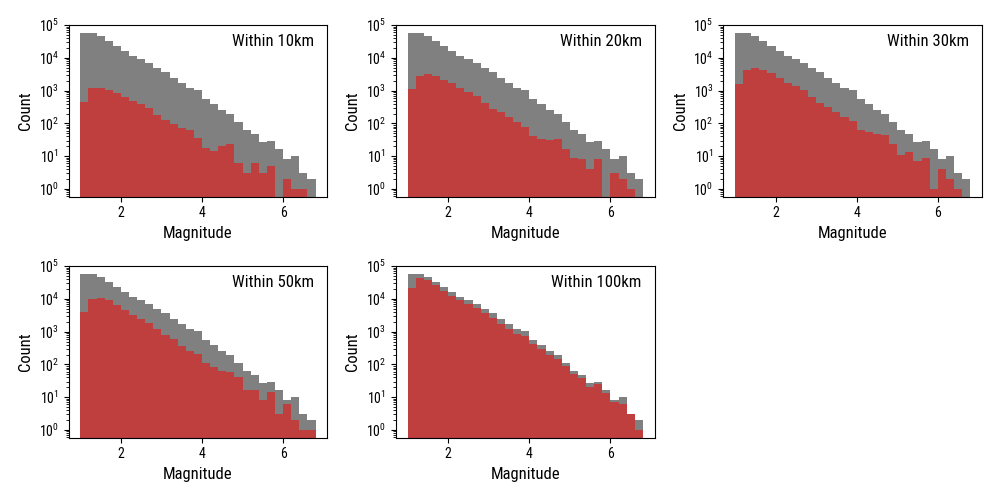

In [40]:
# Magnitude of completeness for each distance

fig, axes = plt.subplots(2, 3, figsize=(10, 5))

for ii in range(6):
    if ii == 5: axes[ii//3, ii%3].remove() ; continue
    ax = axes[ii//3, ii%3]
    ax.set_xlabel('Magnitude')
    ax.set_ylabel('Count')
    ax.set_yscale('log')
    ax.text(.95, .95, 'Within {:d}km'.format(distances[ii]), va='top', ha='right', transform=ax.transAxes)

    ax.hist(eq.mag.values, bins=np.arange(1, 7, .2), fc='gray', ec='none')
    ax.hist(eq.mag[(eq.mag > 1) & (eq.dist2trm < distances[ii])].values, bins=np.arange(1, 7, .2), fc=to_rgba('r', .5), ec='none')

plt.tight_layout()
plt.show()

In [41]:
# Which distance/minimum magnitude for maps
min_mag = 2.2

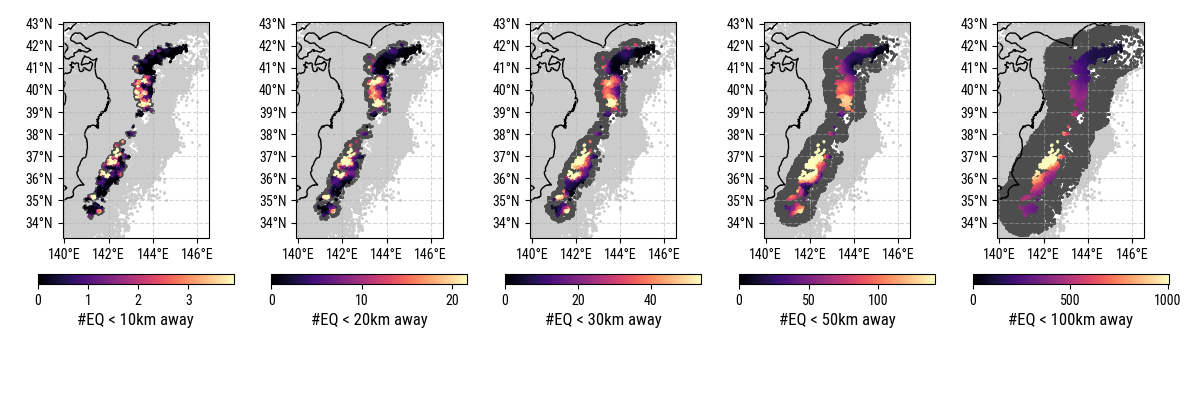

In [46]:
# Maps
lon_min = trm.lon.min() - 1
lon_max = trm.lon.max() + 1
lat_min = trm.lat.min() - 1
lat_max = trm.lat.max() + 1
crs = ccrs.PlateCarree()

fig = plt.figure(figsize=(12, 4))
axes = [plt.subplot(1, 5, ii+1, projection=crs) for ii in range(5)]

for ii, ax in zip(range(len(distances)), np.array(axes).flatten()):
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=crs)
    ax.coastlines(lw=1)

    # Plot tremor
    sc = ax.scatter(trm.lon, trm.lat, c=trm['m{:.1f}in{:d}km'.format(min_mag, distances[ii])], s=1, cmap='magma', transform=crs, vmin=0, vmax=np.percentile(trm['m{:.1f}in{:d}km'.format(min_mag, distances[ii])], 95), zorder=2, label='Tremor')
    ax.scatter(eq[eq.dist2trm < distances[ii]].lon, eq[eq.dist2trm < distances[ii]].lat, c='.3', s=1, transform=crs, zorder=1, label='Earthquakes in range'.format(distances[ii]))
    ax.scatter(eq.lon, eq.lat, c='.8', s=1, transform=crs, zorder=0, label='All earthquakes')

    # Colorbar
    x_min_ax = 0.5; y_min_ax = -0.2
    w_ax = 0.45; h_ax = 0.05
    x_max_ax = x_min_ax + w_ax; y_max_ax = y_min_ax + h_ax

    cbar = plt.colorbar(sc, label="#EQ < {:d}km away".format(distances[ii]), fraction=0.3, pad=0.1, orientation='horizontal')

    # grid and labels, only bottom and left, not top and right
    ax.set_xticks(np.arange(np.ceil(lon_min), lon_max+1, 2), crs=crs)
    ax.set_yticks(np.arange(np.ceil(lat_min), lat_max, 1), crs=crs)
    ax.xaxis.set_major_formatter(LongitudeFormatter())
    ax.yaxis.set_major_formatter(LatitudeFormatter())
    ax.grid('on', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()